# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой группы, сравнить на графике

Дополнительно:
- По любой группе пользователей построить матрицу Пользователь-Паблик, где 1 будет означать факт подписки на определенный паблик, 0 - отсутствие подписки (строки - пользователи, столбцы - паблики) и применить PCA - метод главных компонент, посмотреть, что из себя представляют топ-5 компонент и описать, какие интересы пользователей эти компоненты представляют

In [1]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [73]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=6893269&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [16]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6893269
access_token = 'dec82f5d60724ee43783cf1d76625fce8cfd7e00d6a0f49c8ab9c8372e7fa202ee11017c02d0f8e4548b0'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [17]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 54789

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Лейес Миша


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [26]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

Offset:  155000
Offset:  156000
Offset:  157000
Offset:  158000
Offset:  159000
Offset:  160000
Offset:  161000
Offset:  162000
Offset:  163000
Offset:  164000
Offset:  165000
Offset:  166000
Offset:  167000
Offset:  168000
Offset:  169000
Offset:  170000
Offset:  171000
Offset:  172000
Offset:  173000
Offset:  174000
Offset:  175000
Offset:  176000
Offset:  177000
Offset:  178000
Offset:  179000
Offset:  180000
Offset:  181000
Offset:  182000
Offset:  183000
Offset:  184000
Offset:  185000
Offset:  186000
Offset:  187000
Offset:  188000
Offset:  189000
Offset:  190000
Offset:  191000
Offset:  192000
Offset:  193000
Offset:  194000
Offset:  195000
Offset:  196000
Offset:  197000
Offset:  198000
Offset:  199000
Offset:  200000
Offset:  201000
Offset:  202000
Offset:  203000
Offset:  204000
Offset:  205000
Offset:  206000
Offset:  207000
Offset:  208000
Offset:  209000
Offset:  210000
Offset:  211000
Offset:  212000
Offset:  213000
Offset:  214000
Offset:  215000
Offset:  216000
Offset: 

In [98]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')
ntv_uids = community_ntv_df.uid.unique()
tvrain_uids = community_tvrain_df.uid.unique()

In [99]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [101]:
np.random.seed(42)
ntv_uids = np.setdiff1d(ntv_uids, np.intersect1d(ntv_uids, tvrain_uids))
tvrain_uids = np.setdiff1d(tvrain_uids, np.intersect1d(ntv_uids, tvrain_uids))
# Получим случайную выборку пользователей по 1000 человек из каждой группы.
ntv_uids_sample = np.random.choice(ntv_uids, 1000)
tvrain_uids_sample = np.random.choice(tvrain_uids, 1000)
len(ntv_uids), len(tvrain_uids)

(353130, 444304)

In [102]:
uids = np.concatenate((ntv_uids_sample, tvrain_uids_sample))

In [110]:
# получить подписки этих пользователей
print_counter = 0
final_data = []
top_n = 5
for uid in uids:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', f'user_id={int(uid)}&v=4.9&lang=ru', access_token
        )['response']['groups']
        time.sleep(0.34)
        if user_subs['count']:
            user_subs['uid'] = uid
            user_subs['items'] = user_subs['items'][:top_n]
            final_data.append(user_subs)
            print_counter += 1
    except:
        pass
    if print_counter % 100 == 0:
        print(f"{print_counter} profiles done")

100 profiles done
100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
800 profiles done
900 profiles done
1000 profiles done
1000 profiles done
1000 profiles done
1000 profiles done
1000 profiles done
1100 profiles done
1200 profiles done
1300 profiles done
1300 profiles done
1300 profiles done


In [111]:
save_obj(final_data, 'final_data')

In [112]:
final_data = load_obj('final_data')

In [113]:
subs_list = []
groups_freq_dict = {}
top_n = 5
counter = 0

for record in final_data:
    subs_pd = pd.DataFrame(
        [
            {
                'uid': record.get('uid'),
                'groups_count': record.get('count'),
                'groups_list': record.get('items'),
            }
        ]
    )

    for group_id in record.get('items'):
        groups_freq_dict[group_id] = groups_freq_dict.get(group_id, 0) + 1
        
    subs_list.append(subs_pd)
    counter += 1
    if counter % 100 == 0:
        print(f"Processed {counter} users")

Processed 100 users
Processed 200 users
Processed 300 users
Processed 400 users
Processed 500 users
Processed 600 users
Processed 700 users
Processed 800 users
Processed 900 users
Processed 1000 users
Processed 1100 users
Processed 1200 users
Processed 1300 users


Самые популярные группы

In [114]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(17568841, 194),
 (28658784, 135),
 (15755094, 53),
 (2158488, 38),
 (68519692, 32)]

Загрузка постов со стен групп

In [115]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.3)

100 groups extracted
200 groups extracted
300 groups extracted
400 groups extracted
500 groups extracted
600 groups extracted
700 groups extracted
800 groups extracted
900 groups extracted
Response error. Group id 162134553
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-162134553'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
1000 groups extracted
1100 groups extracted
1200 groups extracted
1300 groups extracted
1400 groups extracted
1500 groups extracted
1600 groups extracted
1700 groups extracted
1800 groups extracted
1900 groups extracted
2000 groups extracted
2100 groups extracted
2200 groups extracted
2300 groups extracted
2400 groups extracted
Response error. Group id 

Response error. Group id 60609780
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-60609780'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 13861810
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-13861810'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 132458763
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 33080201
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-33080201'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 10386492
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-10386492'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 42429577
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 46619709
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-46619709'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 29411855
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-29411855'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
2800 groups extracted
Response error. Group id 30553269
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oau

Response error. Group id 81847917
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-81847917'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 164555412
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-164555412'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 61421935
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 76071995
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-76071995'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 98557384
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-98557384'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 151202069
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 79705900
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-79705900'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 40787464
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-40787464'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 172389703
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 80289923
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-80289923'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 42012475
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-42012475'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 52495021
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 86988244
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-86988244'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 51586631
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-51586631'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
2900 groups extracted
Response error. Group id 66750636
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oau

Response error. Group id 157727808
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-157727808'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 176150053
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-176150053'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 63393495
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}

Response error. Group id 44759043
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-44759043'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 105742269
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-105742269'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 111917431
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 177440968
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-177440968'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 93607698
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-93607698'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 27477956
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 49833607
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-49833607'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 86469403
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-86469403'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 99719303
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 101520046
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-101520046'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 68712983
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-68712983'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3000 groups extracted
Response error. Group id 82757895
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'o

Response error. Group id 90391080
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-90391080'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 64866785
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-64866785'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 35684707
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 19823662
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-19823662'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 154846860
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-154846860'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 30360552
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 69676367
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-69676367'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 91466813
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-91466813'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 7206469
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'k

Response error. Group id 44233743
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-44233743'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 1257511
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-1257511'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 23295337
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'ke

Response error. Group id 34010064
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-34010064'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 50774107
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-50774107'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3100 groups extracted
Response error. Group id 58762466
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oau

Response error. Group id 57369473
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-57369473'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 135886094
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-135886094'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 10635965
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 132679901
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-132679901'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 22167294
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-22167294'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 125004421
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 37432351
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-37432351'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 43973892
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-43973892'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 104168133
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 183079
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-183079'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 4529580
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-4529580'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 16123937
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 

Response error. Group id 28716748
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-28716748'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 61650430
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-61650430'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3200 groups extracted
Response error. Group id 68995594
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oau

Response error. Group id 190902
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-190902'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 24823541
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-24823541'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 26457608
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key'

Response error. Group id 48911100
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-48911100'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 37940440
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-37940440'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 47544817
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 41506169
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-41506169'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 56590488
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-56590488'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 35294456
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 88385441
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-88385441'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 49573982
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-49573982'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 41807730
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 155654539
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-155654539'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 155912620
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-155912620'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3300 groups extracted
Response error. Group id 42224034
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 

Response error. Group id 67250485
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-67250485'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 50553597
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-50553597'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 32654612
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 62067277
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-62067277'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 171636905
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-171636905'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 134473810
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 137647925
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-137647925'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 32742110
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-32742110'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 126212725
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 61689703
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-61689703'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 147042034
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-147042034'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 38094239
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 41088245
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-41088245'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 30250441
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-30250441'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3400 groups extracted
Response error. Group id 2579489
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oaut

Response error. Group id 134382850
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-134382850'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 10928049
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-10928049'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 25450736
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 55159031
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-55159031'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 68769879
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-68769879'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 33880573
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 30712906
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-30712906'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 175228575
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-175228575'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 170937528
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 131717483
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-131717483'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 146791554
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-146791554'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 178845687
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 58122291
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-58122291'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 28181075
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-28181075'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3500 groups extracted
Response error. Group id 84290411
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oau

Response error. Group id 24955130
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-24955130'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 23684028
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-23684028'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 138601784
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 72375839
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-72375839'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 154165355
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-154165355'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 32041317
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 2672569
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-2672569'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 3840268
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-3840268'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 46206970
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key'

Response error. Group id 14415191
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-14415191'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 108040038
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-108040038'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 24704216
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 54426460
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-54426460'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 63399182
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-63399182'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3600 groups extracted
Response error. Group id 59884460
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oau

Response error. Group id 88274923
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-88274923'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 78813123
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-78813123'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 65974416
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 26217154
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-26217154'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 26397586
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-26397586'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 40296507
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 25276999
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-25276999'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 32298967
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-32298967'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 28893181
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 24083427
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-24083427'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 55404958
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-55404958'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 87609135
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 16304557
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-16304557'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 16310204
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-16310204'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3700 groups extracted
Response error. Group id 15810263
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oau

Response error. Group id 77266187
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-77266187'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 36551467
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-36551467'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 40870056
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 23811177
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-23811177'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 34066898
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-34066898'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 142433077
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 2400315
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-2400315'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 31320273
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-31320273'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 65006599
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'ke

Response error. Group id 26547658
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-26547658'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 34486229
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-34486229'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 64641539
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 55387604
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-55387604'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 61395243
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-61395243'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3800 groups extracted
Response error. Group id 115304961
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oa

Response error. Group id 81328594
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-81328594'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 33193420
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-33193420'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 75894058
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 176133048
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-176133048'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 92337511
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-92337511'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 120254617
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 40710957
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-40710957'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 31786047
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-31786047'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 27294566
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 135756433
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-135756433'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 142203134
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-142203134'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 133344012
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 75145700
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-75145700'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 153855784
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-153855784'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
3900 groups extracted
Response error. Group id 83553767
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'o

Response error. Group id 153391819
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-153391819'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 105507655
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-105507655'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 27569095
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}

Response error. Group id 145764999
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-145764999'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 62122883
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-62122883'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 158018939
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 161851950
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-161851950'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 173001067
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-173001067'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 119027934
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 13107790
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-13107790'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 33406351
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-33406351'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 119193519
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 78515560
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-78515560'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 86559535
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-86559535'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
4000 groups extracted
Response error. Group id 163258727
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oa

Response error. Group id 26955088
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-26955088'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 32708863
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-32708863'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 54280690
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 92186575
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-92186575'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 50911295
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-50911295'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 56406664
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 31079309
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-31079309'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 11240145
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-11240145'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 74998389
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 78423275
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-78423275'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 25266684
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-25266684'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 82895734
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

In [116]:
# сохранить сырые данные по постам групп на диск
save_obj(group_doc_dict, 'group_doc_dict')

In [117]:
groups_freq_dict = load_obj('group_doc_dict')

In [118]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [119]:
import nltk


In [120]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [121]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [122]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed


C:\Users\semen\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://smotri-cifru-rf.ru/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed
2700 docs processed


In [124]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

In [125]:
group_clean_doc_dict = load_obj('group_doc_dict_clean')

### Обучение LDA модели

In [126]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=20
)

In [44]:
!pip install gensim

  Running setup.py bdist_wheel for smart-open: started
  Running setup.py bdist_wheel for smart-open: finished with status 'done'
  Stored in directory: C:\Users\semen\AppData\Local\pip\Cache\wheels\f7\a6\ff\9ab5842c14e50e95a06a4675b0b4a689c9cab6064dac2b01d0
  Running setup.py bdist_wheel for bz2file: started
  Running setup.py bdist_wheel for bz2file: finished with status 'done'
  Stored in directory: C:\Users\semen\AppData\Local\pip\Cache\wheels\81\75\d6\e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [127]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 українить який більша буде такожа дуже місто можный потрібный життить
1 алган кызыл болгаш чораан улуг чалапа дээрг болупа чоруп акша
2 уверeнный восстaновление расcтaвание протeстировать оcтыл интeреc человeка… прaктически yжиновый присутcтвие
3 cкоро xороший cкyчнo пoцелyть угpюмый 😆когда даpить букeт пикасcый милoe
4 матч игрок лига чемпион соперник забить тренер футбол болельщик клуб
5 духовный политический враг существование общество происхождение человеческий влияние революция столетие
6 алда шығып алғать жүрген қойғать балас қайрат сайын жатыр екінші
7 ахуеесть прочитанного🔥🔥🔥 darknet нpaвитcть погружение 1357 ķøřø çåмый çнøß мåлęньķøę
8 жақс емес мена үшін айта болада барлық алдын күні керека
9 сантиметр вкус масло форма цвета простой размер тонкий вода небольшой
10 issu маникюр консультирование гибкий индивидуально внимательность карьерный плат продавец-кассир сменный
11 music трек live love time релиз альбом world feat life
12 безмеpный таkий благодаpно

In [128]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 5)

Group distribution by the most relevant topic


17    0.61387
15    0.20803
9     0.09015
0     0.02044
11    0.01788
5     0.01241
4     0.01168
8     0.00547
1     0.00401
12    0.00292
16    0.00255
14    0.00255
7     0.00182
3     0.00182
2     0.00109
18    0.00109
10    0.00073
13    0.00073
6     0.00036
19    0.00036
dtype: float64

In [129]:
# dump lda model to disk
justlda.save('ldamodel_20_topics')

In [130]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 українить який більша буде такожа дуже місто можный потрібный життить
АРТ искусство http://vk.com/club25813425
Канал 1+1 http://vk.com/club6970317
Типичный Киев http://vk.com/club32195333
ТСН http://vk.com/club20035339
Чоткі Українці http://vk.com/club25091591
Деньги или способности? http://vk.com/club155720440
ЛЬВІВ GO - Шукаю у Львові | Книга скарг http://vk.com/club8624345
География в опросах http://vk.com/club73484869
Типова Україна http://vk.com/club34691663
VK Україна http://vk.com/club550910

1 алган кызыл болгаш чораан улуг чалапа дээрг болупа чоруп акша
Тыва Кыстын Чогаалдары http://vk.com/club117181408
Шулуктер бооп хуула берди!!! http://vk.com/club44451041
Кешірші мені жаным http://vk.com/club84369760
Guns http://vk.com/club74641828
сегодня так модно http://vk.com/club159204058
Тувинские ОБСУЖДЕНИЯ для тех, кому за 30 http://vk.com/club75304770
AUTO GID http://vk.com/club163406855
Обои для iPhone http://vk.com/club37743985
Подслушано

Randevu http://vk.com/club106666834
Литературная беседка http://vk.com/club45023794
Идеальная женщина • Женский журнал http://vk.com/club107685474
Психология о жизни http://vk.com/club31478728
Музыка души http://vk.com/club95971513
Женские мысли. http://vk.com/club20753458
депрессия со вкусом вечных драм. http://vk.com/club127768414
Счастье http://vk.com/club35979047
♔ Счастье ♔ http://vk.com/club23337480

16 bellucci ❗magnifier ❤шикарный зaкaж пpoстo пpeдoплaт никакиx экpaнa нyжнo❗ тeлeфoнe❓🙄
ALIEXPRESS♡LOVE http://vk.com/club40718843
Outstanding | Путешествия, Фото http://vk.com/club169184526
1000 фактов http://vk.com/club48338388
Ero Gifs | Эро Гифки http://vk.com/club156713838
МУЖСКИЕ ГИФКИ GIF http://vk.com/club83555757
Улётные приколы | знакомства-бот http://vk.com/club44786979
kiss me http://vk.com/club178335199
• iFace http://vk.com/club30277672
♠ LA MUSIC CAFE ♠ http://vk.com/club156516543
Дома не поймут http://vk.com/club49439086

17 человек группа город март новое друг росси

In [131]:
group_relevant_topic = {}
for group in groups_freq_dict.keys():
    group_topics = {}
    for i in range(20):
        try:
            group_topics[i] = check_pd_20[i][group]
        except:
            group_topics[i] = 0
    group_relevant_topic[group] = max(group_topics, key=group_topics.get)

In [132]:
final_data[0]

{'count': 214,
 'items': [28528027, 33404310, 6970317, 19899031, 22712274],
 'uid': 171808301}

In [133]:
ntv_uids_set = set(ntv_uids_sample)
tvrain_uids_set = set(tvrain_uids_sample)

In [134]:
ntv_users_topic_count = {key: 0 for key in range(20)}
n = len(ntv_uids_set)
for user_data in final_data:
    uid = user_data['uid']
    if uid in ntv_uids_set:
        for i, group in enumerate(user_data['items']):
            group_topic = group_relevant_topic[group]
            ntv_users_topic_count[group_topic] = ntv_users_topic_count[group_topic] + 5 - i
for k, v in ntv_users_topic_count.items():
    ntv_users_topic_count[k] = np.round(v/n, 5)

KeyError: 162134553

In [135]:
ntv_users_topic_count

{0: 55,
 1: 5,
 2: 5,
 3: 8,
 4: 71,
 5: 19,
 6: 2,
 7: 11,
 8: 21,
 9: 255,
 10: 0,
 11: 52,
 12: 15,
 13: 3,
 14: 22,
 15: 784,
 16: 19,
 17: 2342,
 18: 2,
 19: 3}

In [136]:
tvrain_users_topic_count = {key: 0 for key in range(20)}
n = len(tvrain_uids_set)
for user_data in final_data:
    uid = user_data['uid']
    if uid in tvrain_uids_set:
        for i, group in enumerate(user_data['items']):
            group_topic = group_relevant_topic[group]
            tvrain_users_topic_count[group_topic] = tvrain_users_topic_count[group_topic] + 5 - i
for k, v in tvrain_users_topic_count.items():
    tvrain_users_topic_count[k] = np.round(v/n, 5)

KeyError: 33861815

In [137]:
tvrain_users_topic_count

{0: 1,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 14,
 6: 0,
 7: 0,
 8: 0,
 9: 22,
 10: 0,
 11: 1,
 12: 0,
 13: 0,
 14: 0,
 15: 25,
 16: 0,
 17: 132,
 18: 0,
 19: 0}

In [138]:
topics_dict = {}
for i in range(20):
    terms = justlda.get_topic_terms(i)
    topics_dict[i] = ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms))

In [139]:
topics_dict

{0: 'українить який більша буде такожа дуже місто можный потрібный життить',
 1: 'алган кызыл болгаш чораан улуг чалапа дээрг болупа чоруп акша',
 2: 'уверeнный восстaновление расcтaвание протeстировать оcтыл интeреc человeка… прaктически yжиновый присутcтвие',
 3: 'cкоро xороший cкyчнo пoцелyть угpюмый 😆когда даpить букeт пикасcый милoe',
 4: 'матч игрок лига чемпион соперник забить тренер футбол болельщик клуб',
 5: 'духовный политический враг существование общество происхождение человеческий влияние революция столетие',
 6: 'алда шығып алғать жүрген қойғать балас қайрат сайын жатыр екінші',
 7: 'ахуеесть прочитанного🔥🔥🔥 darknet нpaвитcть погружение 1357 ķøřø çåмый çнøß мåлęньķøę',
 8: 'жақс емес мена үшін айта болада барлық алдын күні керека',
 9: 'сантиметр вкус масло форма цвета простой размер тонкий вода небольшой',
 10: 'issu маникюр консультирование гибкий индивидуально внимательность карьерный плат продавец-кассир сменный',
 11: 'music трек live love time релиз альбом world fe

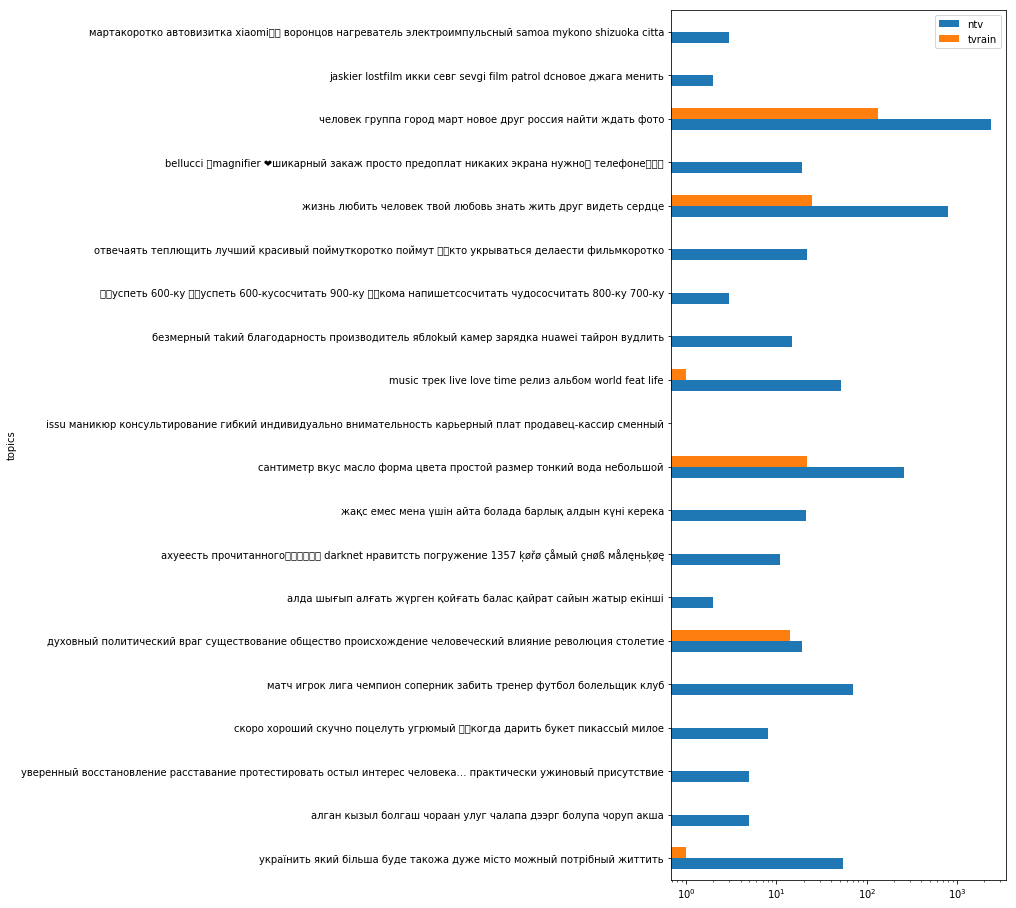

In [148]:
ntv_vs_tvrain_df = pd.DataFrame([topics_dict, ntv_users_topic_count, tvrain_users_topic_count]).T
ntv_vs_tvrain_df.columns = ['topics', 'ntv', 'tvrain']
ntv_vs_tvrain_df.plot(x = 'topics', y=['ntv', 'tvrain'], kind='barh', logx=True, figsize=(6,16))